# 데이터 불러오기
* 3추차 실습 파일에서 참고했음

In [38]:
import sys
import sklearn
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tarfile
import urllib.request
import pandas as pd

In [39]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# housing 파일 불러오기
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [40]:
fetch_housing_data()
housing = load_housing_data()

In [41]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [42]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# 전처리

In [43]:
# 결측치 확인
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [44]:
housing['total_bedrooms'] = housing['total_bedrooms'].fillna(0)

In [45]:
housing.isnull().sum()
# 결측치가 잘 처리 되었음을 알 수 있음

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [46]:
# 문자형 변수 전처리
# 어떤 값들이 존재하는지 확인
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# train, test 데이터 나누기

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing.drop('median_house_value',1), housing['median_house_value'], test_size=0.2, random_state=11)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [48]:
X_train.shape, y_train.shape

((16512, 9), (16512,))

# 표준화 및 인코딩
* 경사 하강법을 사용할 것이기 떄문에 특성들의 스케일을 맞춰주는 작업을 수행

In [49]:
# ColumnTransformer로 표준화와 인코딩 전처리
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

obj_features = ['ocean_proximity']
num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
                'population', 'households', 'median_income']

ct = ColumnTransformer([
    ('encoding', OneHotEncoder(), obj_features),
    ('scaling', StandardScaler(), num_features)
])

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

# 모델 학습

## 실험1 : epoch=50, t0=1, t1=50
* 기본(하이퍼파리미터 설정 X)

In [ ]:
X_train.shape, y_train.shape

((16512, 13), (16512,))

In [ ]:
n_epochs = 50
t0, t1 = 5, 50

# 학습 스케줄 : 매 반복에서 학습률을 결정
def learning_schedule(t):
  return t0 / (t+t1)

theta = np.random.randn(13, 1) # random initialiazation
m = len(X_train)

for epoch in range(n_epochs): # 에포크만큼 반복
  for i in range(m):
    random_index = pd.Series(np.random.randint(m))

    # X_train = X_train.reshape(-1, 2)
    y_train = np.array(y_train)
    y_train = y_train.reshape(-1, 1)

    xi = X_train[int(random_index):int(random_index)+1]
    yi = y_train[int(random_index):int(random_index)+1]

    gradients = 2 * xi.T.dot(xi.dot(theta) - yi) # .T : transpose 역할
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [ ]:
theta # 위에서 구한 최적의 파라미터

array([[220690.26387433],
       [178210.42255795],
       [  2964.16391299],
       [215803.47215306],
       [225294.87084072],
       [-49822.75404632],
       [-50035.27005176],
       [ 13984.29650363],
       [-15729.58258004],
       [ 53107.19506377],
       [-42253.24640035],
       [ 10681.90543001],
       [ 75914.6512855 ]])

In [ ]:
X_train.shape, y_train.shape

((16512, 13), (16512, 1))

In [50]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, tol=1e-3, penalty=None, eta0=0.1, random_state=11)
sgd_reg.fit(X_train, y_train)

SGDRegressor(eta0=0.1, max_iter=50, penalty=None, random_state=11)

In [51]:
sgd_reg.intercept_, sgd_reg.coef_

(array([179471.48190401]),
 array([ 42699.18336616,  -1375.48193094,  57226.91993128,  33869.16326763,
         47051.69726987, -56120.06875587, -54210.8494644 ,  10239.51833401,
        -15285.16696716,  21724.06335833, -50680.351125  ,  45427.82984477,
         72838.6470348 ]))

> SGDRegressor로 학습시킨 파라미터 근처에 도달할 수 있었음을 알 수 있음

> 다만, 세부적인 튜닝 및 에포크 수 변경으로 더욱 최적인 해를 찾아볼 필요가 있음

In [ ]:
from sklearn.metrics import mean_squared_error

sgd_reg_params = np.concatenate((sgd_reg.intercept_, sgd_reg.coef_), axis=0)
theta_ravel = theta.ravel()
theta_a = np.append(theta, np.array([0]))

params_error_1 = mean_squared_error(sgd_reg_params, theta_a)
params_error_1

8800002003.72048

## 실험2 : epoch=100, t0-5, t1=100

In [ ]:
n_epochs = 100
t0, t1 = 5, 100

# 학습 스케줄 : 매 반복에서 학습률을 결정
def learning_schedule(t):
  return t0 / (t+t1)

theta = np.random.randn(13, 1) # random initialiazation
m = len(X_train)

for epoch in range(n_epochs): # 에포크만큼 반복
  for i in range(m):
    random_index = pd.Series(np.random.randint(m))

    # X_train = X_train.reshape(-1, 2)
    y_train = np.array(y_train)
    y_train = y_train.reshape(-1, 1)

    xi = X_train[int(random_index):int(random_index)+1]
    yi = y_train[int(random_index):int(random_index)+1]

    gradients = 2 * xi.T.dot(xi.dot(theta) - yi) # .T : transpose 역할
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [ ]:
theta

array([[218429.77915997],
       [184567.87309641],
       [  4490.5211729 ],
       [211745.07784462],
       [219518.722576  ],
       [-63547.212684  ],
       [-64924.17166398],
       [ 14005.35251287],
       [ -8384.22625733],
       [ 33129.8507061 ],
       [-45846.38352507],
       [ 25086.24393207],
       [ 73670.63027326]])

In [ ]:
theta_ravel = theta.ravel()
theta_a = np.append(theta, np.array([0]))

params_error_2 = mean_squared_error(sgd_reg_params, theta_a)
params_error_2

8860285527.581581

> 에포크를 늘리고 학습률을 더 작게 해주었음에도 성능차이는 거의 없었음. 오히려 조금 늘었음

## 실험3 : epoch=500, t0=1, t1=300

In [ ]:
n_epochs = 500
t0, t1 = 1, 300

# 학습 스케줄 : 매 반복에서 학습률을 결정
def learning_schedule(t):
  return t0 / (t+t1)

theta = np.random.randn(13, 1) # random initialiazation
m = len(X_train)

for epoch in range(n_epochs): # 에포크만큼 반복
  for i in range(m):
    random_index = pd.Series(np.random.randint(m))

    # X_train = X_train.reshape(-1, 2)
    y_train = np.array(y_train)
    y_train = y_train.reshape(-1, 1)

    xi = X_train[int(random_index):int(random_index)+1]
    yi = y_train[int(random_index):int(random_index)+1]

    gradients = 2 * xi.T.dot(xi.dot(theta) - yi) # .T : transpose 역할
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [ ]:
theta

array([[223496.38900311],
       [174978.80384381],
       [  1255.55129226],
       [185938.13526365],
       [212747.73682185],
       [-50537.29709591],
       [-46609.9111791 ],
       [ 16740.20675833],
       [ -4813.37221731],
       [ 32114.71254466],
       [-45564.78632084],
       [ 24259.72018442],
       [ 74043.96053499]])

In [ ]:
theta_ravel = theta.ravel()
theta_a = np.append(theta, np.array([0]))

params_error_3 = mean_squared_error(sgd_reg_params, theta_a)
params_error_3

7752094318.935706

> 에포크와 학습 스케줄 변화를 크게 주었더니 오차값에서도 유의미하게 감소했음

# SGDRegressor 모델 학습 곡선

In [ ]:
from sklearn.metrics import mean_squared_error

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

    # 정규화 및 표준화
    X_train = ct.fit_transform(X_train)
    X_val = ct.transform(X_val)

    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

In [ ]:
X = housing.drop('median_house_value', 1)
y = housing['median_house_value']

# 보기 좋지 않은 불필요한 콘솔창 지우는 모듈
from google.colab import output

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


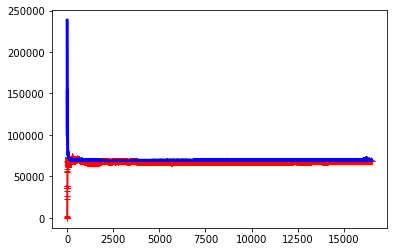

In [ ]:
plot_learning_curves(sgd_reg, X, y)

# 콘솔 화면 지우기
output.clear()

# 조기 종료 이용해보기

In [52]:
from copy import deepcopy

sgd_reg = SGDRegressor(max_iter=50, tol=1e-3, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.1, random_state=11)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

X_train_poly_scaled = ct.fit_transform(X_train)
X_val_poly_scaled = ct.transform(X_test)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_test, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

In [53]:
best_epoch, best_model

(344,
 SGDRegressor(eta0=0.1, learning_rate='constant', max_iter=50, penalty=None,
              random_state=11, warm_start=True))

In [54]:
sgd_reg.intercept_, sgd_reg.coef_

(array([-11734.52910928]),
 array([  396989.3256687 ,   204821.06880359, -1195761.96414571,
          220673.93635347,   361543.09604657,   -62664.57371093,
         -163149.94030402,  -127683.71679841,   325069.82712123,
          878968.58826029,   659510.05872039,   138430.17902945,
          386502.3333078 ]))

* 조기종료를 사용하지 않고 학습시켰을 때 파라미터
```
(array([179471.48190401]),
 array([ 42699.18336616,  -1375.48193094,  57226.91993128,  33869.16326763,
         47051.69726987, -56120.06875587, -54210.8494644 ,  10239.51833401,
        -15285.16696716,  21724.06335833, -50680.351125  ,  45427.82984477,
         72838.6470348 ]))
```

* epoch=300일 때 파라미터
```
array([[223496.38900311],
       [174978.80384381],
       [  1255.55129226],
       [185938.13526365],
       [212747.73682185],
       [-50537.29709591],
       [-46609.9111791 ],
       [ 16740.20675833],
       [ -4813.37221731],
       [ 32114.71254466],
       [-45564.78632084],
       [ 24259.72018442],
       [ 74043.96053499]])
```

> 확률적으로 경사하는 하강법이어서 그런지 매 학습시 안정적으로 학습되진 않았음